## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import json
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import wandb

import torch
import torchvision.transforms.v2 as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision.models import resnet34, ResNet34_Weights

from src.models import MultiObjectNet, CustomBackbone
from src.dataset import FashionDataset
from src.loss import Loss
from src.utils import collate, train, create_transforms


## Image and GT data visualization

(880, 1320)
dict_keys(['segmentation', 'scale', 'viewpoint', 'zoom_in', 'landmarks', 'style', 'bounding_box', 'category_id', 'occlusion', 'category_name'])
[0, 2, 851, 606] long sleeve top


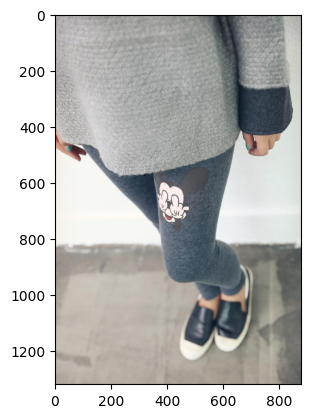

In [3]:
train_anno = glob.glob("data/train/annotations/*")
train_images = [f.replace("annotations", "images").replace(".json", ".jpg") for f in train_anno]
with open(train_anno[-1], 'r') as f:
    anno = json.load(f)

img = Image.open(train_images[-1])
print(img.size)
plt.imshow(img)
print(anno["item1"].keys())
print(anno["item1"]["bounding_box"], anno["item1"]["category_name"])

## Dataset mean and std computation

In [4]:
tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
])
def c(batch):
    images,_,_ = zip(*batch)
    return torch.stack(images)
dummy_dataset = FashionDataset("train", "data/train/annotations", "data/train/images", transforms={"img":tf})
dl = DataLoader(dummy_dataset, batch_size=64, shuffle=False, collate_fn=c)
# placeholders
psum    = torch.tensor([0.0,0.0,0.0])
psum_sq = torch.tensor([0.0,0.0,0.0])

# loop through images
for inputs in tqdm.tqdm(dl):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])
    
# pixel count
count = len(dummy_dataset) * 224 * 224

# mean and STD
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('Train data stats:')
print('- mean: {}'.format(total_mean))
print('- std:  {}'.format(total_std))

/Users/lorenzo/.pyenv/versions/3.10.9/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
100%|██████████| 286/286 [01:56<00:00,  2.47it/s]

Train data stats:
- mean: tensor([0.6068, 0.5726, 0.5510])
- std:  tensor([0.2902, 0.2961, 0.2872])


In [30]:
use_imagenet_norm = False
train_transforms = create_transforms("train", use_imagenet_norm)
test_transforms = create_transforms("test", use_imagenet_norm)

train_dataset = FashionDataset("train", "data/train/annotations", "data/train/images", train_transforms)
test_dataset = FashionDataset("test", "data/test/annotations", "data/test/images", test_transforms)

MAX_OBJS = 5
max_classes = 13 + 1

custom_backbone = False
if custom_backbone:
    backbone=CustomBackbone(in_size=224,
                            use_self_attention=True, 
                            hidden_dim=64)
else:
    resnet = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
    backbone = nn.Sequential(
            *list(resnet.children())[:-2], # Remove avgpool and fc
            nn.Conv2d(512, 256, 1) # Dimensionality reduction
        )
    
net = MultiObjectNet(in_size=224, 
                     max_objects=MAX_OBJS, 
                     num_classes=max_classes, 
                     backbone=backbone
                    )

batch_size = 8
num_workers = 0
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate)

dataloaders = {
    "train": train_dataloader,
    "test": test_dataloader
}

lr = 1e-4
momentum = 0.9
loss_fn = Loss(max_classes, 0.4, 0.2, 0.4, warmup_epochs=0, learn_balance_weights=False)

if custom_backbone:
    optimizer = torch.optim.Adam(net.parameters(), lr)
else:
    optimizer = torch.optim.Adam([
            {"params": net.backbone.parameters(), "lr": 1e-5},
            {"params": net.decoder.parameters(), "lr": 2e-4},
            {"params": net.queries, "lr": 2e-4},
            {"params": net.category.parameters(), "lr": 2e-4},
            {"params": net.boxes.parameters(), "lr": 2e-4},
        ])
    
if loss_fn.learn_balance_weights:
    optimizer.add_param_group({"params":list(loss_fn.parameters()), "lr":lr})
device = torch.device("cuda")

## Train and test

In [ ]:
net.to(device)

n_epochs = 7
use_wandb = False
try:
    loss_results = train(net, loss_fn, optimizer, dataloaders, device, n_epochs, use_wandb)
finally:
    if use_wandb:
        wandb.finish()

## Display results

Detected classes:  [('long sleeve top', 0.9867781400680542), ('trousers', 0.9993057250976562)]
Ground truth classes:  ['long sleeve top', 'trousers']


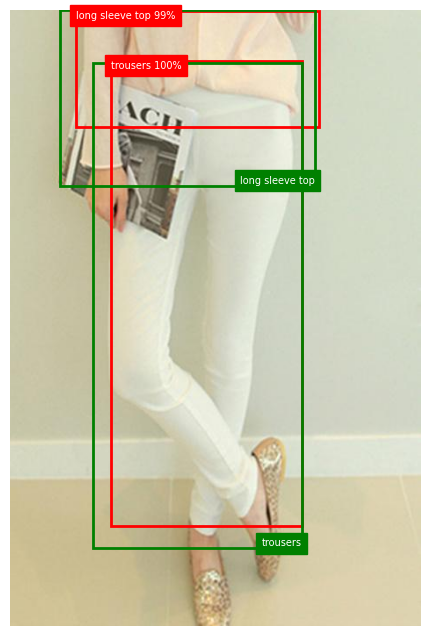

In [ ]:
cat_names = [
    "no detection",
    "short sleeve top", 
    "long sleeve top", 
    "short sleeve outwear", 
    "long sleeve outwear", 
    "vest", 
    "sling", 
    "shorts", 
    "trousers", 
    "skirt", 
    "short sleeve dress", 
    "long sleeve dress", 
    "vest dress", 
    "sling dress"
    ]

net.load_state_dict(torch.load("checkpoints/resnet_backbone.pth"))
transforms_test = create_transforms("test", False)
ds = FashionDataset("test", "data/test/annotations", "data/test/images", transforms_test)
device = torch.device("mps")
idx = np.random.randint(len(ds)) # Indexes of the images used in the README: 1385, 292, 695
img, cat, boxes = ds[idx]
net.to(device)
net.eval()
with torch.no_grad():
    pred_cat, pred_boxes = net(img.to("mps"))
pred_cat = pred_cat.cpu()
pred_boxes = pred_boxes.cpu()
softmaxed_preds, softmaxed_indices = F.softmax(pred_cat, dim=-1).max(-1)
valid = (softmaxed_indices != 0) & (softmaxed_preds >= 0.5)


detected_classes = [(cat_names[i], s.item()) for s,i in zip(*pred_cat[valid].softmax(-1).max(-1))]
print("Detected classes: ", detected_classes)

print("Ground truth classes: ", [cat_names[i] for i in cat])
image_np = Image.open(ds.anno[idx].replace("json","jpg").replace("annotations","images"))
#image_np = img.cpu().permute(1,2,0).numpy()

# Image dimensions
W, H = image_np.size
#H,W,_ = image_np.shape

converted_boxes = transforms.functional.convert_bounding_box_format(pred_boxes[valid], old_format="CXCYWH", new_format="XYXY")

# Plot with matplotlib
fig, ax = plt.subplots(figsize=(8,8))
#plt.imshow((image_np - image_np.min())/(image_np.max() - image_np.min()))
plt.imshow(image_np)

for (cls_id, score), box in zip(detected_classes,converted_boxes):
    x1, y1, x2, y2 = box * np.array([W,H,W,H])
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                         fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    ax.text(x1,y1, f"{cls_id} {score*100:.0f}%", bbox=dict(color="red"), fontsize=7, color="white", horizontalalignment="left", verticalalignment="top")

for c, box in zip(cat,boxes):
    box = transforms.functional.convert_bounding_box_format(box, old_format="CXCYWH", new_format="XYXY")
    x1,y1,x2,y2 = box * np.array([W,H,W,H])
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                         fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)
    ax.text(x2,y2, f"{cat_names[c]}", bbox=dict(color="green"), fontsize=7, color="white", horizontalalignment="right", verticalalignment="bottom")

plt.axis("off")
plt.show()